# Import needed libraries
To make things work ensure that you have this libraries installed. \
`pip install -r requirements.txt`

In [55]:
import os
import random
import librosa
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import soundfile as sf  # Library for saving audio files
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict 
from typing import Tuple, List, Generator, Optional

# Environment variables
In the Google Colab environment, variables are stored in userdata. Therefore, we need to load them. \
Please note that in order to proceed, you will need a Kaggle token. If you do not already have one, you can create one through your Kaggle account.

In [2]:
try:
  from google.colab import userdata
  os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
  os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
  print('Running on CoLab')
except:
  print('Not running on CoLab')

Not running on CoLab


# Dataset
Download and extract the [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) dataset from Kaggle. Ensure that you have installed the Kaggle API. If you have not yet installed it, please do so. \
\
`pip install kaggle`

In [3]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!tar -xvf gtzan-dataset-music-genre-classification.zip

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


x Data/features_30_sec.csv
x Data/features_3_sec.csv
x Data/genres_original/blues/blues.00000.wav
x Data/genres_original/blues/blues.00001.wav
x Data/genres_original/blues/blues.00002.wav
x Data/genres_original/blues/blues.00003.wav
x Data/genres_original/blues/blues.00004.wav
x Data/genres_original/blues/blues.00005.wav
x Data/genres_original/blues/blues.00006.wav
x Data/genres_original/blues/blues.00007.wav
x Data/genres_original/blues/blues.00008.wav
x Data/genres_original/blues/blues.00009.wav
x Data/genres_original/blues/blues.00010.wav
x Data/genres_original/blues/blues.00011.wav
x Data/genres_original/blues/blues.00012.wav
x Data/genres_original/blues/blues.00013.wav
x Data/genres_original/blues/blues.00014.wav
x Data/genres_original/blues/blues.00015.wav
x Data/genres_original/blues/blues.00016.wav
x Data/genres_original/blues/blues.00017.wav
x Data/genres_original/blues/blues.00018.wav
x Data/genres_original/blues/blues.00019.wav
x Data/genres_original/blues/blues.00020.wav
x 

# Data augmentation
To enhance the input data, data augmentation was applied. The 1,000 audio snippets in the original GTZAN dataset have slightly varying durations, which makes them unsuitable for model input. Therefore, each audio clip in the original dataset was randomly sampled within a continuous 3-second frame at five non-overlapping random positions to correct this issue and increase the amount of data. The dataset was expanded by using this method to include 5,000 three-second audio snippets.

In [4]:
def split_audio(
        audio_file: Tuple[np.ndarray, int] | str,
        from_second: int = 0,
        to_second: Optional[int] = None,
        save_file_path: Optional[str] = None,
        ) -> Tuple[np.ndarray, int]:
    """
    This code splits an audio file based on the provided seconds
    
    Args:
        audio_file (tuple): an audio file loaded by librosa
        from_second (int): the second when the split starts
        to_second (int, optional): the second when the split ends
        save_file_path (str, optional): if provided audio snippet will be saved at location

    Returns:
        A tuple containing the audio snippet as ndarray and sample_rate
    """

    audio_file, sr = audio_file

    # last second is end of file if not provided
    to_second = len(audio_file) if to_second is None else to_second
    # split audio
    audio_file = audio_file[from_second*sr:to_second*sr]

    if save_file_path is not None and isinstance(save_file_path, str):
        # add extension if necessary
        save_file_path, ext = os.path.splitext(save_file_path)
        save_file_path = save_file_path + ".wav" if not ext else save_file_path + ext
        # save to file
        sf.write(save_file_path, audio_file, sr)

    return audio_file, sr

def generate_non_overlapping_sequences(
        start: int,
        end: int,
        num_sequences: int = 3,
        num_samples: int = 5
        ) -> Generator[Tuple[int, int], None, None]:
    """
    Generate non-overlapping sequences of numbers within a given range.

    Args:
        start (int): The starting number of the range.
        end (int): The ending number of the range.
        num_sequences (int, optional): The number of sequences to generate. Defaults to 3.
        num_samples (int, optional): The number of samples to generate. Defaults to 5.

    Yields:
        A tuple containing the first and last number of each generated sequence.

    """
    sequences = 0
    used_numbers = set()

    while sequences < num_samples:
        sequence = []
        start_number = random.randint(start, end - num_sequences)  # Ensure space for a 3-digit sequence
        if start_number in used_numbers or start_number + 2 in used_numbers:
            continue  # Skip if starting number or next two numbers are already used

        for i in range(start_number, start_number + num_sequences + 1):
            if i in used_numbers:
                break  # Skip if any number in the sequence is already used
            sequence.append(i)
        else:
            used_numbers.update(sequence)
            sequences += 1
            yield (sequence[0], sequence[-1])

def augment_audio(
        file_path: str = None,
        duration: int = 3,
        num_samples: int = 5,
        save_file_path: Optional[str] = None
        ) -> List[Tuple[np.ndarray, int]]:
    """
    Augments the audio file by generating non-overlapping sequences of specified duration and number of samples.

    Args:
        file_path (str): The path to the audio file.
        duration (int): The duration of each sequence in seconds.
        num_samples (int): The number of sequences to generate.
        save_file_path (str, optional): The path to save the augmented audio files. If None, the files will not be saved.

    Returns:
        A list of tuples containing the augmented audio data and sample rate.

    """
    augmented_audio = []
    file_name, _ = os.path.splitext(os.path.basename(file_path))
    try:
        audio_data, sample_rate = librosa.load(file_path, sr=None)    
    except:
        logging.error(f"Failed loading file {file_path}")
        return []

    for i, sequence in enumerate(
            generate_non_overlapping_sequences(
                0, 30,
                num_sequences=duration,
                num_samples=num_samples
            )
        ):
        augmented_audio.append(
            split_audio(
                (audio_data, sample_rate),
                from_second=sequence[0],
                to_second=sequence[1],
                save_file_path=f"{save_file_path}/{file_name}.{i}.wav" if save_file_path else None
            )
        )

    return augmented_audio

# Path to the directory containing audio files
data_dir = "./Data/genres_original"
augmented_data_dir = "./Data/genres_augmented"

# Create save directory if it does not exist
os.makedirs(augmented_data_dir, exist_ok=True)

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    os.makedirs(os.path.join(augmented_data_dir, folder), exist_ok=True) # Create subdirectory for each genre
    for f in tqdm(os.listdir(folder_path), desc = f'Processing folder {folder}'):
        file_path = os.path.join(folder_path, f)
        augment_audio(file_path=file_path, save_file_path=f"{augmented_data_dir}/{os.path.basename(folder_path)}")

print("All files augmented and saved successfully.")


Processing folder jazz:  54%|█████▍    | 54/100 [00:00<00:00, 65.86it/s]C:\Users\micha\AppData\Local\Temp\ipykernel_5948\2789861777.py:95: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None)
c:\workspace\MusicGenrePrediction\.venv\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
ERROR:root:Failed loading file ./Data/genres_original\jazz\jazz.00054.wav
Processing folder rock: 100%|██████████| 100/100 [00:01<00:00, 59.35it/s]

All files augmented and saved successfully.


# Raw audio

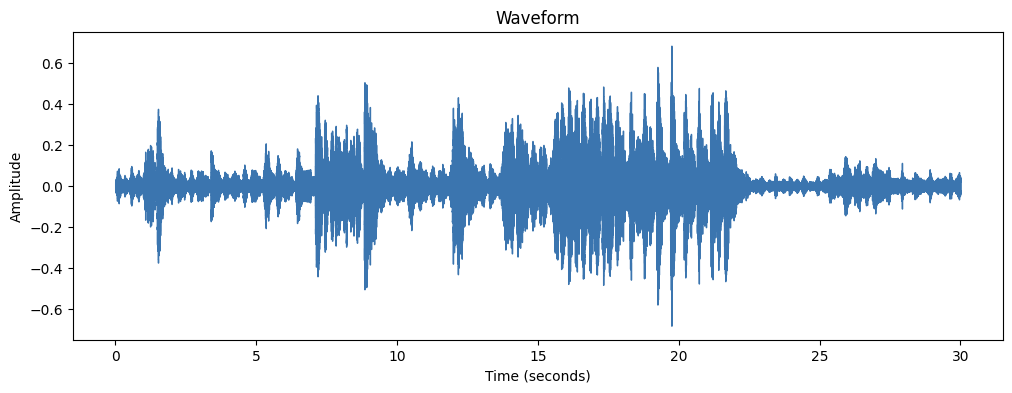

In [5]:
# Load audio file
raw_audio, sample_rate = librosa.load('./Data/genres_original/jazz/jazz.00000.wav', sr=None)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(raw_audio, sr=sample_rate, color='#3b75af')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

# Short-Time Fourier Transform
STFT function takes a signal in the time domain as input and outputs its frequency decomposition. Transform the y-axis (frequency) to a logarithmic scale and the 'color' axis (amplitude) to decibels, which approximates the logarithmic scale of amplitudes.

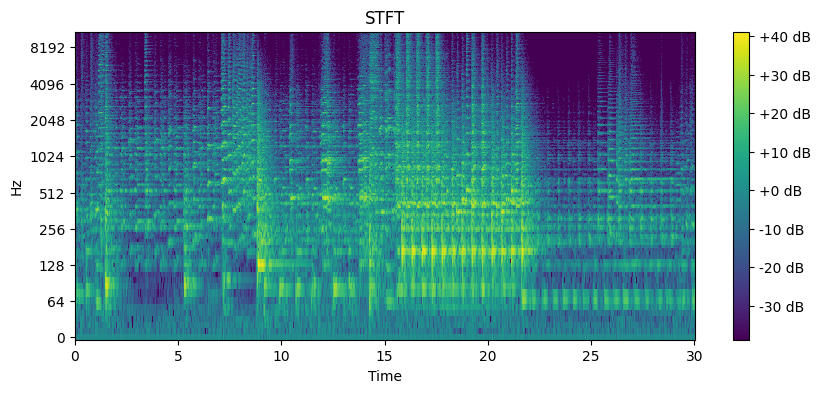

In [6]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Compute Short-Time Fourier Transform (STFT)
stft = librosa.amplitude_to_db(np.abs(librosa.stft(raw_audio, n_fft=n_fft, hop_length=hop_length)))

# Plot STFT
plt.figure(figsize=(10, 4))
librosa.display.specshow(stft, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT')
plt.show()

# Mel Spectogram
The Mel Scale is a non-linear transformation of the frequency scale. The Mel Spectrogram is a normal Spectrogram with a Mel Scale on the y-axis.

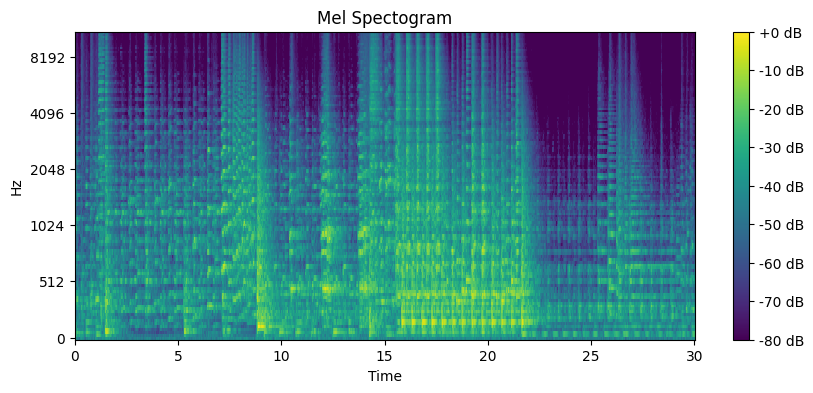

In [7]:
mel_spectrogram = librosa.feature.melspectrogram(S=np.abs(librosa.stft(raw_audio, n_fft=n_fft, hop_length=hop_length)) ** 2, sr=sample_rate)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectogram')
plt.show()

# Preprocessing Data

In [8]:
@dataclass(frozen=True)
class AudioFeatures:
    file_name: str
    genre: str
    raw_audio: str
    stft: str
    mel_spectrogram: str

    dict = asdict

def extract_features(file_path: str, raw_audio_dir: str, stft_dir: str, mel_spectrogram_dir: str, n_fft: int = 2048, hop_length: int = 512) -> AudioFeatures:
    """
    Extracts audio features from a given audio file.

    Args:
        file_path (str): The path to the audio file.
        raw_audio_dir (str): The path to save the image files.
        stft_dir (str): The path to save the image files.
        mel_spectrogram_dir (str): The path to save the image files.
        n_fft (int, optional): The number of FFT points. Defaults to 2048.
        hop_length (int, optional): The number of samples between successive frames. Defaults to 512.

    Returns:
        AudioFeatures: An object containing the extracted audio features.
    """
    raw_audio_file_path = os.path.join(raw_audio_dir, os.path.basename(file_path)).replace('.wav', '.png')
    stft_file_path = os.path.join(stft_dir, os.path.basename(file_path)).replace('.wav', '.png')
    mel_spectrogram_file_path = os.path.join(mel_spectrogram_dir, os.path.basename(file_path)).replace('.wav', '.png')

    if os.path.exists(raw_audio_file_path) and os.path.exists(stft_file_path) and os.path.exists(mel_spectrogram_file_path):
        return AudioFeatures(
            os.path.basename(file_path),
            os.path.basename(os.path.dirname(file_path)),
            raw_audio=raw_audio_file_path,
            stft=stft_file_path,
            mel_spectrogram=mel_spectrogram_file_path
        )

    # Load raw audio
    raw_audio, sample_rate = librosa.load(file_path, sr=None)

    # Save raw audio
    librosa.display.waveshow(raw_audio, sr=sample_rate, color='#3b75af')
    plt.axis('off')
    plt.xlim([0, int(len(raw_audio)/sample_rate)])
    plt.savefig(raw_audio_file_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Compute Short-Time Fourier Transform (STFT)
    stft = np.abs(librosa.stft(raw_audio, n_fft=n_fft, hop_length=hop_length))

    # Save STFT
    librosa.display.specshow(
        librosa.amplitude_to_db(stft, ref=np.max),
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        x_axis='time',
        y_axis='log',
        cmap='viridis'
    )
    plt.axis('off')
    plt.xlim([0, int(len(raw_audio)/sample_rate)])
    plt.savefig(stft_file_path, bbox_inches='tight', pad_inches=0)
    plt.close()


    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(S=stft**2, sr=sample_rate)

    # Save Mel spectrogram
    librosa.display.specshow(
        librosa.power_to_db(mel_spectrogram, ref=np.max),
        sr=sample_rate,
        x_axis='time',
        y_axis='mel',
        cmap='viridis'
    )
    plt.axis('off')
    plt.xlim([0, int(len(raw_audio)/sample_rate)])
    plt.savefig(mel_spectrogram_file_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return AudioFeatures(
            os.path.basename(file_path),
            os.path.basename(os.path.dirname(file_path)),
            raw_audio=raw_audio_file_path,
            stft=stft_file_path,
            mel_spectrogram=mel_spectrogram_file_path
        )

def make_dataset(data_dir: str, save_file_path: str, n_fft: int = 2048, hop_length: int = 512) -> pd.DataFrame:
    """
    Create a dataset by extracting features from audio files in the given directory.

    Args:
        data_dir (str): The directory path containing the audio files.
        save_file_path (str): The path to save the image files. If None, the files will not be saved.
        n_fft (int, optional): The number of samples per frame for the Fourier transform. Defaults to 2048.
        hop_length (int, optional): The number of samples between successive frames. Defaults to 512.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted features from the audio files.
    """
    data = []

    # Create save directory if it does not exist
    os.makedirs(save_file_path, exist_ok=True)
    
    raw_audio_dir = os.path.join(save_file_path, 'raw_audio')
    stft_dir = os.path.join(save_file_path, 'stft')
    mel_spectrogram_dir = os.path.join(save_file_path, 'mel_spectrogram')

    os.makedirs(raw_audio_dir, exist_ok=True)
    os.makedirs(stft_dir, exist_ok=True)
    os.makedirs(mel_spectrogram_dir, exist_ok=True)

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)

        genre_raw_audio_dir = os.path.join(raw_audio_dir, folder)
        genre_stft_dir = os.path.join(stft_dir, folder)
        genre_mel_spectrogram_dir = os.path.join(mel_spectrogram_dir, folder)

        # Create subdirectory for each genre
        os.makedirs(genre_raw_audio_dir, exist_ok=True)
        os.makedirs(genre_stft_dir, exist_ok=True)
        os.makedirs(genre_mel_spectrogram_dir, exist_ok=True)

        for f in tqdm(os.listdir(folder_path), desc=f'Processing folder {folder}'):
            file_path = os.path.join(folder_path, f)
            features = extract_features(
                    file_path,
                    raw_audio_dir=genre_raw_audio_dir,
                    stft_dir=genre_stft_dir,
                    mel_spectrogram_dir=genre_mel_spectrogram_dir,
                    n_fft=n_fft,
                    hop_length=hop_length
                )
            data.append(features.dict())

    return pd.DataFrame(data)

# Create dataset
dataset = make_dataset(augmented_data_dir, save_file_path='./Data/images_augmented') # Use augmented data directory

Processing folder rock: 100%|██████████| 500/500 [00:00<00:00, 7444.50it/s]


In [54]:
# Save dataset
dataset.to_csv('./Data/dataset.csv', index=False)
dataset.head()

,file_name,genre,raw_audio,stft,mel_spectrogram
0,blues.00000.0.wav,blues,./Data/images_augmented/raw_audio/blues/blues....,./Data/images_augmented/stft/blues/blues.00000...,./Data/images_augmented/mel_spectrogram/blues/...
1,blues.00000.1.wav,blues,./Data/images_augmented/raw_audio/blues/blues....,./Data/images_augmented/stft/blues/blues.00000...,./Data/images_augmented/mel_spectrogram/blues/...
2,blues.00000.2.wav,blues,./Data/images_augmented/raw_audio/blues/blues....,./Data/images_augmented/stft/blues/blues.00000...,./Data/images_augmented/mel_spectrogram/blues/...
3,blues.00000.3.wav,blues,./Data/images_augmented/raw_audio/blues/blues....,./Data/images_augmented/stft/blues/blues.00000...,./Data/images_augmented/mel_spectrogram/blues/...
4,blues.00000.4.wav,blues,./Data/images_augmented/raw_audio/blues/blues....,./Data/images_augmented/stft/blues/blues.00000...,./Data/images_augmented/mel_spectrogram/blues/...


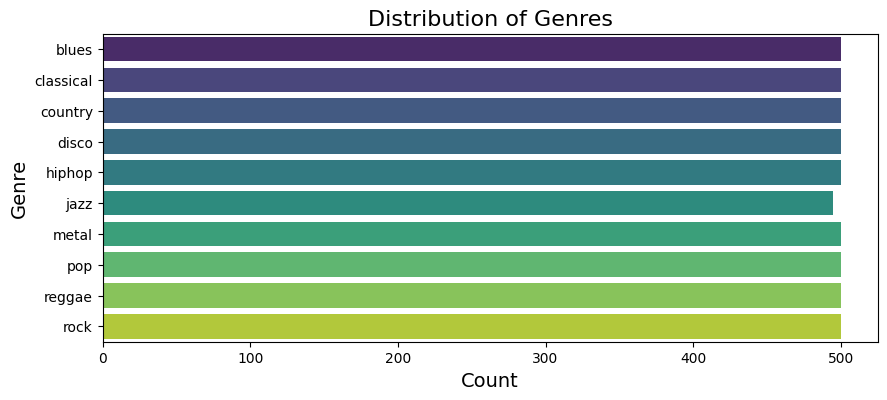

In [10]:
# Plotting count distribution of genres
plt.figure(figsize = (10, 4))
sns.countplot(y=dataset['genre'], hue=dataset['genre'], palette='viridis', legend=False)
plt.title('Distribution of Genres', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Genre', fontsize = 14)
plt.show()

<Figure size 640x480 with 0 Axes>

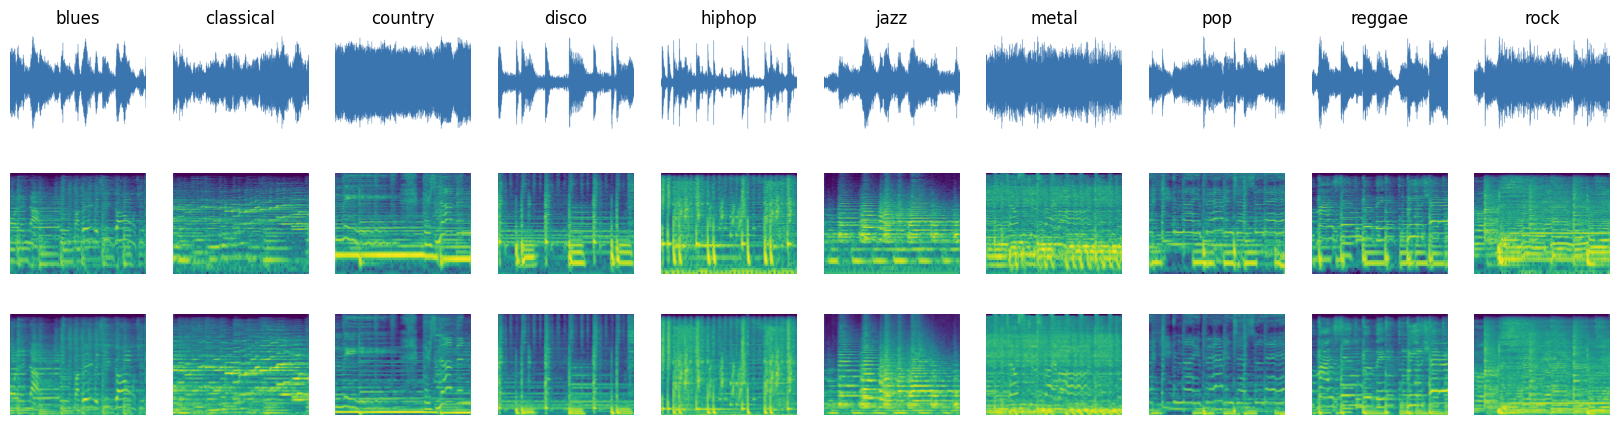

In [51]:
# Plotting the audio features

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

plt.clf()
fig, axes = plt.subplots(3, len(genres), figsize=(16, 16))

for i, genre in enumerate(genres):
    axes[0, i].imshow(plt.imread(f'./Data/images_augmented/raw_audio/{genre}/{genre}.00000.0.png'))
    axes[0, i].set_title(genre)
    axes[0, i].axis('off')

    axes[1, i].imshow(plt.imread(f'./Data/images_augmented/stft/{genre}/{genre}.00000.0.png'))
    axes[1, i].axis('off')


    axes[2, i].imshow(plt.imread(f'./Data/images_augmented/mel_spectrogram/{genre}/{genre}.00000.0.png'))
    axes[2, i].axis('off')

plt.subplots_adjust(left=0, right=1, bottom=0, top=0.25)
plt.show()